# Describe the strategy and benchmark

  Our project focuses on using momentum strategy and add filters to see if we can generate different results from class. we combined compustat and crsp data, and set up 4 criterias. We excluded the market cap in lower 30% to make sure penny stocks won't have impact to our results. Price/Book ratio shoulde be lower than 40, Price/Earnings ratio less than 30, and ROE ratio less than 40. In this way we eliminate outliers, and hope this method show us a clearer pattern for momentum strategy along with time.
 
  Benchmark is imported from Fama_french research data, basically it is an interpretaion of Market returns (Market Excess Returns). We want to see if there exists advantage for the momentum strategy to outperform investment in market index funds.
  
  We think our strategy should outperform the benchmark, because momentum method keeps focusing on portfoilo with top performances stocks. We think short-term profits generated by this strategy will eventually become long-term outperformance.

In [1]:
# Summarize the characteristics of stocks in the strategy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Import the benchmark file. 
# We consider Market Excess Return as our Benchmark.

ff = pd.read_csv(
    '..Code/Data/F-F_Research_Data_Factors.CSV',
    index_col=0,
    skiprows=3,
    nrows=12*(2020 - 1927 + 1) + 6 + 1
)
ff.index = pd.to_datetime(ff.index, format='%Y%m') + pd.offsets.MonthEnd(0)
ff /= 100

In [3]:
# Import CRSP data (monthly prices and returns)

df = pd.read_csv(
    '../Code/Data/crsp-2021-01-14.csv', 
    parse_dates=['date'], 
    na_values=['A', 'B', 'C'], 
    usecols=['PERMNO', 'date', 'RET', 'PRC', 'SHROUT', 'SHRCD'])

df = df[df['SHRCD'].isin([10, 11])]
df.drop_duplicates(subset=['PERMNO','date'], inplace=True)
df.sort_values(['date', 'PERMNO'], inplace=True)

In [4]:
# Import compustat data (enables us to calculate different ratios)

compustat = pd.read_csv(
    '../Code/Data/compustat-2021-01-14.csv', 
    parse_dates=['datadate']
)
compustat.sort_values(['datadate', 'LPERMNO'], inplace=True) 
compustat.drop_duplicates(subset=['datadate','LPERMNO'], inplace=True, keep='last') 

In [5]:
# move the dates to the last day of the month

df['date'] += pd.offsets.MonthEnd(0)
compustat['datadate'] += pd.offsets.MonthEnd(0)

In [6]:
# merge crsp + computstat, to the NEW "crsp" DataFrame

crsp = pd.merge_asof(df, compustat, 
                   left_on='date', right_on='datadate', 
                   left_by='PERMNO', right_by='LPERMNO'
                  )
crsp.sort_values(['PERMNO', 'date'], inplace=True)

# Make sure crsp common equity is greater than ZERO.
crsp = crsp[crsp['ceq'] > 0]

# Set up stock selection criterias



In [7]:
# Filter the data with market cap 70% top. 
# We wouldn't want penny stock movements to affect our judgement.

crsp['MKTCPA'] = np.abs(crsp['PRC']) * crsp['SHROUT']
crsp['MKTCPA'].quantile(0.3)

31733.649999999994

In [8]:
# Execute MC criteria.

crsp=crsp[crsp['MKTCPA']>31733.65]

In [9]:
### Setup 3 ratios.

# Filter the data with price/book ratio
crsp['p_b'] = (np.abs(crsp['PRC']) * crsp['SHROUT'] / 1000) / crsp['ceq']

# Filter the data with price/earnings ratio
crsp['p_e'] = crsp['csho'] * crsp['prcc_f'] / crsp['ni']


# Filter the data with ROE
crsp['roe'] = crsp['ni'] / crsp['ceq']

In [10]:
### Restrict3 ratio ranges. 
### Any ratio changes/ideas can be modified in this and previous column.

crsp = crsp[(crsp['date'].dt.year >= 1926)].copy() 


crsp = crsp.loc[    (crsp['p_b'] > 0) & 
                    (crsp['p_b'] < 40) & 
                    (crsp['p_e'] > 0  ) & 
                    (crsp['p_e'] < 30 ) &
                    (crsp['roe'] > 0  ) &
                    (crsp['roe'] < 40 )  
                     ]
crsp

,PERMNO,date,SHRCD,PRC,RET,SHROUT,GVKEY,LPERMNO,LPERMCO,datadate,...,dltt,dvc,ni,oibdp,costat,prcc_f,MKTCPA,p_b,p_e,roe
2947116,10001,2005-09-30,11.0,11.51,0.211579,2913.0,12994.0,10001.0,7953.0,2005-06-30,...,18.677,0.0,1.381,6.679,I,9.05,33528.63,1.950813,19.089537,0.080351
2976697,10001,2006-03-31,11.0,10.99,0.170394,2932.0,12994.0,10001.0,7953.0,2005-06-30,...,18.677,0.0,1.381,6.679,I,9.05,32222.68,1.874829,19.089537,0.080351
3001120,10001,2006-08-31,11.0,11.63,0.123574,2934.0,12994.0,10001.0,7953.0,2006-06-30,...,17.605,0.0,2.317,7.451,I,9.02,34122.42,1.780455,11.421959,0.120897
3005982,10001,2006-09-30,11.0,11.00,-0.054170,2947.0,12994.0,10001.0,7953.0,2006-06-30,...,17.605,0.0,2.317,7.451,I,9.02,32417.00,1.691469,11.421959,0.120897
3010840,10001,2006-10-31,11.0,11.08,0.007273,2947.0,12994.0,10001.0,7953.0,2006-06-30,...,17.605,0.0,2.317,7.451,I,9.02,32652.76,1.703770,11.421959,0.120897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3267325,93435,2011-07-31,11.0,2.05,0.708333,23782.0,144356.0,93435.0,53452.0,2010-12-31,...,0.160,0.0,48.005,36.822,I,6.61,48753.10,0.582210,3.229199,0.573276
3271251,93435,2011-08-31,11.0,1.55,-0.243902,23782.0,144356.0,93435.0,53452.0,2010-12-31,...,0.160,0.0,48.005,36.822,I,6.61,36862.10,0.440208,3.229199,0.573276
3294598,93435,2012-02-29,11.0,1.50,0.181102,23864.0,144356.0,93435.0,53452.0,2011-12-31,...,0.000,0.0,32.125,26.388,I,1.00,35796.00,0.299992,0.732856,0.269227
3298453,93435,2012-03-31,11.0,2.69,0.793333,23864.0,144356.0,93435.0,53452.0,2011-12-31,...,0.000,0.0,32.125,26.388,I,1.00,64194.16,0.537986,0.732856,0.269227


In [11]:
# After criteria applies, sort/rearrange data once more to make sure everything goes smooth.

crsp.sort_values(['PERMNO', 'date', 'RET'], inplace=True)
crsp.drop_duplicates(subset=['PERMNO', 'date'], inplace=True)

crsp

,PERMNO,date,SHRCD,PRC,RET,SHROUT,GVKEY,LPERMNO,LPERMCO,datadate,...,dltt,dvc,ni,oibdp,costat,prcc_f,MKTCPA,p_b,p_e,roe
2947116,10001,2005-09-30,11.0,11.51,0.211579,2913.0,12994.0,10001.0,7953.0,2005-06-30,...,18.677,0.0,1.381,6.679,I,9.05,33528.63,1.950813,19.089537,0.080351
2976697,10001,2006-03-31,11.0,10.99,0.170394,2932.0,12994.0,10001.0,7953.0,2005-06-30,...,18.677,0.0,1.381,6.679,I,9.05,32222.68,1.874829,19.089537,0.080351
3001120,10001,2006-08-31,11.0,11.63,0.123574,2934.0,12994.0,10001.0,7953.0,2006-06-30,...,17.605,0.0,2.317,7.451,I,9.02,34122.42,1.780455,11.421959,0.120897
3005982,10001,2006-09-30,11.0,11.00,-0.054170,2947.0,12994.0,10001.0,7953.0,2006-06-30,...,17.605,0.0,2.317,7.451,I,9.02,32417.00,1.691469,11.421959,0.120897
3010840,10001,2006-10-31,11.0,11.08,0.007273,2947.0,12994.0,10001.0,7953.0,2006-06-30,...,17.605,0.0,2.317,7.451,I,9.02,32652.76,1.703770,11.421959,0.120897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3267325,93435,2011-07-31,11.0,2.05,0.708333,23782.0,144356.0,93435.0,53452.0,2010-12-31,...,0.160,0.0,48.005,36.822,I,6.61,48753.10,0.582210,3.229199,0.573276
3271251,93435,2011-08-31,11.0,1.55,-0.243902,23782.0,144356.0,93435.0,53452.0,2010-12-31,...,0.160,0.0,48.005,36.822,I,6.61,36862.10,0.440208,3.229199,0.573276
3294598,93435,2012-02-29,11.0,1.50,0.181102,23864.0,144356.0,93435.0,53452.0,2011-12-31,...,0.000,0.0,32.125,26.388,I,1.00,35796.00,0.299992,0.732856,0.269227
3298453,93435,2012-03-31,11.0,2.69,0.793333,23864.0,144356.0,93435.0,53452.0,2011-12-31,...,0.000,0.0,32.125,26.388,I,1.00,64194.16,0.537986,0.732856,0.269227


# Apply momentum method

The method is zero investment: meaning to long the top 10% highest return stocks, and short the bottom 10% lowest return stocks.

We do have concerns about this strategy, because past returns never represent current price change or the future price movement. Stocks with abnormal high return will be considered "winner" stocks using momentum method, but this abnormal profit may disappear quickly, making our "winner" to "underperform".

In [12]:
# We focus on yearly(12 month) rerurn, and name the result into a new column 'RET12'

crsp.loc[crsp.groupby('PERMNO').head(1).index, 'RET'] = np.nan
crsp['RET12'] = np.exp(np.log(1 + crsp['RET']).rolling(12).sum()) - 1

In [13]:
# Add the 2-month lagged yearly return into the crsp DataFrame.

temp = crsp[['PERMNO', 'date', 'RET12']].copy()

# Lag two months to make sure the stock is unaffected by short-term reversal.
temp['date'] += pd.offsets.MonthEnd(2)

# Merge the previous 12-month returns to crsp with _lag2 suffix.
merged = pd.merge(
    left=crsp,
    right=temp.dropna(),
    how='inner',
    on=['PERMNO', 'date'],
    suffixes=['', '_lag2'])

In [14]:
# Add the 1-month lagged Market Cap to be precise, giving the beginning month Market Equity

temp = crsp[['PERMNO', 'date', 'MKTCPA']].copy()

temp['date'] += pd.offsets.MonthEnd(1)

merged = pd.merge(
    left=merged,
    right=temp.dropna(),
    how='inner',
    on=['PERMNO', 'date'],
    suffixes=['', '_lag1'])
merged

,PERMNO,date,SHRCD,PRC,RET,SHROUT,GVKEY,LPERMNO,LPERMCO,datadate,...,oibdp,costat,prcc_f,MKTCPA,p_b,p_e,roe,RET12,RET12_lag2,MKTCPA_lag1
0,10001,2007-08-31,11.0,-14.54,0.027562,2859.0,12994.0,10001.0,7953.0,2007-06-30,...,7.104,I,15.00,41569.86,1.864454,6.903574,0.278615,0.288454,0.747952,40454.85
1,10001,2007-09-30,11.0,13.91,-0.032325,2856.0,12994.0,10001.0,7953.0,2007-06-30,...,7.104,I,15.00,39726.96,1.781798,6.903574,0.278615,0.318212,0.408843,41569.86
2,10001,2007-10-31,11.0,13.35,-0.040259,2855.0,12994.0,10001.0,7953.0,2007-06-30,...,7.104,I,15.00,38114.25,1.709466,6.903574,0.278615,0.256007,0.288454,39726.96
3,10001,2007-11-30,11.0,14.25,0.079401,2858.0,12994.0,10001.0,7953.0,2007-06-30,...,7.104,I,15.00,40726.50,1.826628,6.903574,0.278615,0.289403,0.318212,38114.25
4,10001,2007-12-31,11.0,14.14,-0.003930,2875.0,12994.0,10001.0,7953.0,2007-06-30,...,7.104,I,15.00,40652.50,1.823309,6.903574,0.278615,0.334089,0.256007,40726.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035069,93429,2019-07-31,11.0,109.31,0.054810,111710.0,184500.0,93429.0,53447.0,2018-12-31,...,834.700,A,97.83,12211020.10,3.767671,25.677384,0.131194,0.030835,0.110212,11576507.30
1035070,93429,2019-08-31,11.0,119.16,0.093404,111682.0,184500.0,93429.0,53447.0,2018-12-31,...,834.700,A,97.83,13308027.12,4.106148,25.677384,0.131194,0.124830,0.009250,12211020.10
1035071,93429,2019-09-30,11.0,114.91,-0.035666,111682.0,184500.0,93429.0,53447.0,2018-12-31,...,834.700,A,97.83,12833378.62,3.959697,25.677384,0.131194,0.148941,0.030835,13308027.12
1035072,93429,2019-10-31,11.0,115.15,0.002089,111682.0,184500.0,93429.0,53447.0,2018-12-31,...,834.700,A,97.83,12860182.30,3.967967,25.677384,0.131194,0.181213,0.124830,12833378.62


In [15]:
# Bye bye outflows.

del temp

In [16]:
# Merge our Returns, 1 month lag returns, 2 month lag returns.

merged.dropna(subset=['RET', 'RET12_lag2', 'MKTCPA_lag1'], inplace=True)

In [17]:
# create ten momentum portfolios based on the 2-month lag of 12-month returns.

merged['RET12_lag2_q10'] = merged.groupby('date')['RET12_lag2'].\
transform(lambda x: pd.qcut(x, 10, labels=False, duplicates = 'drop')) + 1

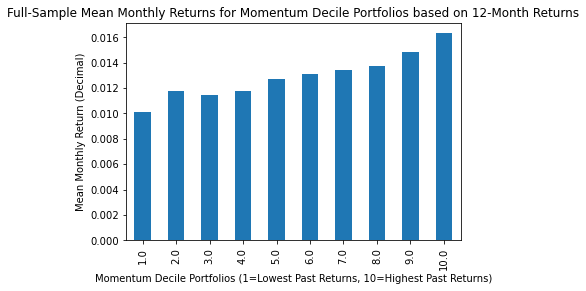

In [18]:
# Make sure the plot is more read-able.

merged.groupby('RET12_lag2_q10')['RET'].mean().plot(kind='bar')
plt.xlabel('Momentum Decile Portfolios (1=Lowest Past Returns, 10=Highest Past Returns)')
plt.ylabel('Mean Monthly Return (Decimal)')
plt.title('Full-Sample Mean Monthly Returns for Momentum Decile Portfolios based on 12-Month Returns')
plt.show()

Theoretically, the graph shows us the profitability of longing winners and shorting losers. Theoretically, we can generate (0.016-0.010) percentage returns simply by buying top 10% and selling bottom 10%.

In [19]:
# Equally-weighted return for each portfolio each month

long = merged.groupby(['date', 'RET12_lag2_q10'])[['RET']].mean()
long.rename(columns={'RET': 'RET_EW'}, inplace=True)

In [20]:
# Create Value Weighted Portfolio DataFrame.

long['RET_VW'] = merged.groupby(['date', 'RET12_lag2_q10'])\
                .apply(lambda x: np.average(x['RET'], weights=x['MKTCPA_lag1']))

In [21]:
long

RET_EW    RET_VW
date       RET12_lag2_q10                    
1963-08-31 1.0             0.132530  0.132530
           4.0             0.154762  0.154762
           7.0             0.070175  0.070175
           10.0            0.076710  0.076710
1963-09-30 1.0            -0.111111 -0.111111
...                             ...       ...
2019-12-31 6.0             0.025030  0.026870
           7.0             0.027089  0.046769
           8.0             0.021138  0.019328
           9.0             0.017158  0.033326
           10.0           -0.002961  0.025440

[6757 rows x 2 columns]

In [22]:
# make our portfolios to appear in the columns, not rows.

wide = long.unstack()
wide.columns = [col[0] + '_' + str(int(col[1])) for col in wide.columns.values]
wide

,RET_EW_1,RET_EW_2,RET_EW_3,RET_EW_4,RET_EW_5,RET_EW_6,RET_EW_7,RET_EW_8,RET_EW_9,RET_EW_10,RET_VW_1,RET_VW_2,RET_VW_3,RET_VW_4,RET_VW_5,RET_VW_6,RET_VW_7,RET_VW_8,RET_VW_9,RET_VW_10
date,,,,,,,,,,,,,,,,,,,,
1963-08-31,0.132530,NaN,NaN,0.154762,NaN,NaN,0.070175,NaN,NaN,0.076710,0.132530,NaN,NaN,0.154762,NaN,NaN,0.070175,NaN,NaN,0.076710
1963-09-30,-0.111111,NaN,-0.046243,NaN,0.035161,NaN,NaN,-0.005181,NaN,-0.017486,-0.111111,NaN,-0.046243,NaN,0.035161,NaN,NaN,-0.005181,NaN,-0.017486
1963-10-31,-0.035211,-0.072727,-0.075313,NaN,0.017877,0.052885,NaN,0.003484,0.057292,-0.045326,-0.035211,-0.072727,-0.075313,NaN,0.017877,0.052885,NaN,0.003484,0.057292,-0.045326
1963-11-30,0.105720,0.002538,0.055794,-0.025114,-0.056738,-0.051111,0.011525,0.002967,0.014778,-0.022099,0.128417,0.002538,0.055794,-0.025114,-0.056738,-0.051111,0.011525,0.002967,0.014778,-0.022099
1963-12-31,-0.025397,-0.012412,0.018750,0.009628,0.060843,0.018243,0.039604,0.090083,0.015819,-0.032372,-0.057805,-0.015467,0.018750,0.009409,0.060843,0.006503,0.039604,0.065104,0.015819,0.007970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,-0.110318,-0.070465,-0.059376,-0.060415,-0.050140,-0.041782,-0.044633,-0.015963,-0.022627,-0.045259,-0.143951,-0.093800,-0.089282,-0.051884,-0.043660,-0.046010,-0.018846,0.001295,-0.014508,-0.008235
2019-09-30,0.083873,0.056331,0.063814,0.058399,0.041459,0.052248,0.036381,0.035177,0.033814,0.025682,0.073893,0.059659,0.033116,0.056137,0.022300,0.040228,0.041009,0.043690,0.014893,0.014395
2019-10-31,-0.027360,0.030817,0.014528,0.040000,0.028358,0.023661,0.024721,0.006664,0.014995,0.011873,-0.049233,0.049459,0.012658,0.046181,0.040510,0.064149,0.033602,0.002534,0.009465,0.014033


In [23]:
# long the Winners and Short the Losers.

wide['WML_EW'] = wide['RET_EW_10'] - wide['RET_EW_1']
wide['WML_VW'] = wide['RET_VW_10'] - wide['RET_VW_1']

In [24]:
# This is where we import the risk-free data and start to make comparison.

wide = wide.join(ff)
wide.rename(columns={'Mkt-RF': 'Mkt_RF'}, inplace=True)

# Compare strategy and benchmark, analyze the performance

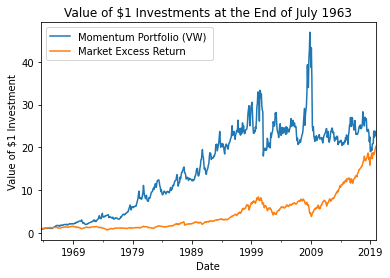

In [25]:
# Make comparison with market returns and our strategy.
# graph looks confusing.

wide[['WML_VW', 'Mkt_RF']].add(1).cumprod().plot()
plt.legend(['Momentum Portfolio (VW) ', 'Market Excess Return'])
plt.ylabel('Value of \$1 Investment')
plt.xlabel('Date')
plt.title('Value of \$1 Investments at the End of ' + (wide.index[0] - pd.offsets.MonthEnd()).strftime(format='%B %Y'))
plt.show()

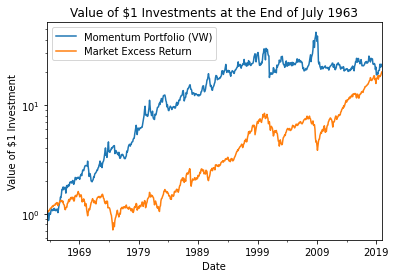

In [26]:
# try to see the pattern in log scale
# Momentum strategy is getting less effective comparing to the 70s and 80s.

wide[['WML_VW', 'Mkt_RF']].add(1).cumprod().plot()
plt.legend(['Momentum Portfolio (VW)', 'Market Excess Return'])
plt.ylabel('Value of \$1 Investment')
plt.xlabel('Date')
plt.title('Value of \$1 Investments at the End of ' + (wide.index[0] - pd.offsets.MonthEnd()).strftime(format='%B %Y'))
plt.semilogy()
plt.show()

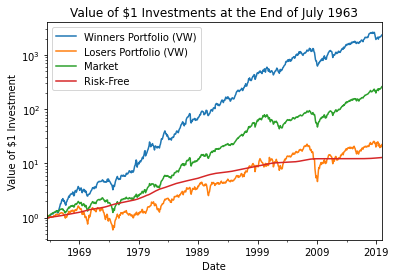

In [27]:
# Make a cross-comparison between winners/losers, market returns and rf.
# Trying to figure out what causes the momentum effect to generally become ineffective.

wide['MktRet'] = wide['Mkt_RF'] + wide['RF']

wide[['RET_VW_10', 'RET_VW_1', 'MktRet', 'RF']].add(1).cumprod().plot()
plt.legend(['Winners Portfolio (VW)', 'Losers Portfolio (VW)', 'Market', 'Risk-Free'])
plt.ylabel('Value of \$1 Investment')
plt.xlabel('Date')
plt.title('Value of \$1 Investments at the End of ' + (wide.index[0] - pd.offsets.MonthEnd()).strftime(format='%B %Y'))
plt.semilogy()
plt.show()

In [28]:
# Plot rolling portfolio volatilities over time for your strategy and benchmark

port=wide[['WML_VW','Mkt_RF','SMB','HML','RF']]
port

,WML_VW,Mkt_RF,SMB,HML,RF
date,,,,,
1963-08-31,-0.055820,0.0507,-0.0102,0.0182,0.0025
1963-09-30,0.093625,-0.0157,-0.0031,0.0017,0.0027
1963-10-31,-0.010115,0.0253,-0.0057,-0.0004,0.0029
1963-11-30,-0.150516,-0.0085,-0.0115,0.0170,0.0027
1963-12-31,0.065776,0.0183,-0.0201,-0.0006,0.0029
...,...,...,...,...,...
2019-08-31,0.135716,-0.0258,-0.0240,-0.0485,0.0016
2019-09-30,-0.059497,0.0143,-0.0105,0.0677,0.0018
2019-10-31,0.063266,0.0206,0.0024,-0.0188,0.0015


<ipython-input-29-0bb34db0f491>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  port['WML_VW_std']=port['WML_VW'].rolling(12).std()*np.sqrt(12)
<ipython-input-29-0bb34db0f491>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  port['Mkt_std']=port['Mkt_RF'].rolling(12).std()*np.sqrt(12)


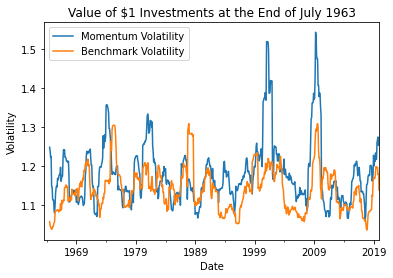

In [29]:
# Volatility measure graphs 
# momentum is more volatile than the overall Market.

port['WML_VW_std']=port['WML_VW'].rolling(12).std()*np.sqrt(12)
port['Mkt_std']=port['Mkt_RF'].rolling(12).std()*np.sqrt(12)
port[['WML_VW_std', 'Mkt_std']].add(1).plot()

plt.legend(['Momentum Volatility', 'Benchmark Volatility'])
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.title('Value of \$1 Investments at the End of ' + (port.index[0] - pd.offsets.MonthEnd()).strftime(format='%B %Y'))
plt.show()

In [30]:
#  Alpha and beta for strategy

# alpha is significantly positive, meaning it has a risk adjusted problem.
# counters efficient market hypothesis.
# shorted beta is higher than longed beta!!

import statsmodels.formula.api as smf
smf.ols(
    formula='WML_VW ~ Mkt_RF',
    data=wide
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 WML_VW   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     7.957
Date:                Wed, 28 Apr 2021   Prob (F-statistic):            0.00493
Time:                        19:51:54   Log-Likelihood:                 979.12
No. Observations:                 677   AIC:                            -1954.
Df Residuals:                     675   BIC:                            -1945.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0071      0.002      3.207      0.001       0.003       0.011
Mkt_RF        -0.1410      0.050     -2.821      0.005      -0.239      -0.043
==============================================================================
Omnibus:                      119.135   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              655.413
Skew:                          -0.656   Prob(JB):                    4.77e-143
Kurtosis:                       7.638   Cond. No.                         22.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
# We try to make the significant alpha disappear by adding HML and SMB as CAPM method suggests,
# Turns out the alpha still exists.

smf.ols(
    formula='WML_VW ~ Mkt_RF+SMB+HML',
    data=wide
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 WML_VW   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     15.34
Date:                Wed, 28 Apr 2021   Prob (F-statistic):           1.15e-09
Time:                        19:51:54   Log-Likelihood:                 997.55
No. Observations:                 677   AIC:                            -1987.
Df Residuals:                     673   BIC:                            -1969.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0089      0.002      4.096      0.000       0.005       0.013
Mkt_RF        -0.2273      0.052     -4.360      0.000      -0.330      -0.125
SMB            0.0506      0.074      0.683      0.495      -0.095       0.196
HML           -0.4734      0.079     -5.960      0.000      -0.629      -0.317
==============================================================================
Omnibus:                      147.000   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              904.825
Skew:                          -0.813   Prob(JB):                    3.31e-197
Kurtosis:                       8.425   Cond. No.                         38.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

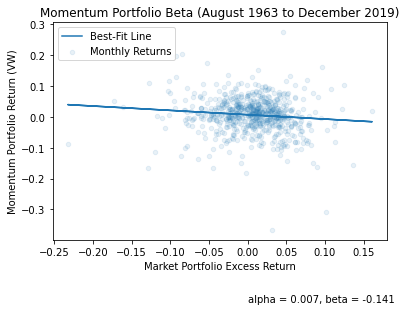

In [32]:
# Plot the regression graph.

temp = wide.copy()
temp_reg = np.polyfit(temp['Mkt_RF'], temp['WML_VW'], 1)

temp.plot(kind='scatter', x='Mkt_RF', y='WML_VW', alpha=0.1)
plt.plot(
    temp['Mkt_RF'], 
    np.polyval(temp_reg, temp['Mkt_RF'])
)
plt.text(0, -0.6, 'alpha = {:.3f}, beta = {:.3f}'.format(temp_reg[1], temp_reg[0]))
plt.legend(['Best-Fit Line', 'Monthly Returns'])
plt.xlabel('Market Portfolio Excess Return')
plt.ylabel('Momentum Portfolio Return (VW)')
plt.title(
    'Momentum Portfolio Beta (' + temp.index.min().strftime(format='%B %Y') + ' to ' + temp.index.max().strftime(format='%B %Y') + ')'
)
plt.show()

<ipython-input-33-9ba0deb14610>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  port['port_sharp']=(port['WML_VW']-port['RF']).rolling(window=12).mean()/(port['WML_VW']-port['RF']).rolling(window=12).std()*np.sqrt(12)
<ipython-input-33-9ba0deb14610>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  port['Mkt_sharp']=port['Mkt_RF'].rolling(window=12).mean()/port['Mkt_RF'].rolling(12).std()*np.sqrt(12)


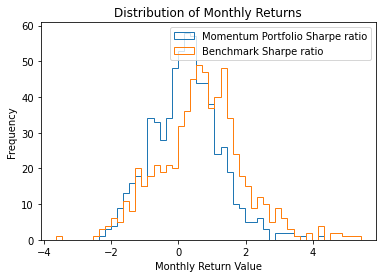

In [33]:
# Plot rolling Sharpe ratios over time for strategy and benchmark.
# momentum strategy forms a skewed distribution.
# omentum Portfolio has greater the value of the Sharpe ratio during the around 0 monthly return, 
# it indicates the more attractive the risk-adjusted return than the benchmark.

port['port_sharp']=(port['WML_VW']-port['RF']).rolling(window=12).mean()/(port['WML_VW']-port['RF']).rolling(window=12).std()*np.sqrt(12)
port['Mkt_sharp']=port['Mkt_RF'].rolling(window=12).mean()/port['Mkt_RF'].rolling(12).std()*np.sqrt(12)
port[['port_sharp','Mkt_sharp']].plot(kind='hist', bins=50, histtype='step', logy=False)
plt.legend(['Momentum Portfolio Sharpe ratio','Benchmark Sharpe ratio'])
plt.xlabel('Monthly Return Value')
plt.title('Distribution of Monthly Returns')
plt.show()

<ipython-input-34-1f752b5e4c65>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  port['Sortino']=(port['WML_VW']-port['RF']).rolling(12).mean()/(port['WML_VW']).rolling(12).std()*np.sqrt(12)


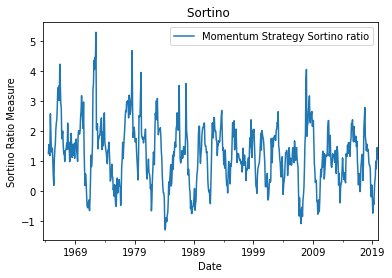

In [34]:
# Sortino Ratio Measure
# 

port['Sortino']=(port['WML_VW']-port['RF']).rolling(12).mean()/(port['WML_VW']).rolling(12).std()*np.sqrt(12)
port[['Sortino']].add(1).plot()
plt.legend(['Momentum Strategy Sortino ratio'])
plt.ylabel('Sortino Ratio Measure')
plt.xlabel('Date')
plt.title('Sortino ')
plt.show()

<ipython-input-35-b4031ece4f3d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  port['information']=(port['WML_VW']-port['Mkt_RF']).rolling(12).mean()/(port['WML_VW']-port['Mkt_RF']).rolling(12).std()*np.sqrt(12)


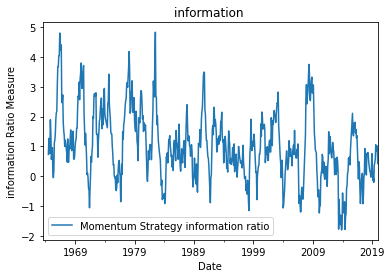

In [35]:
#  Information ratio

port['information']=(port['WML_VW']-port['Mkt_RF']).rolling(12).mean()/(port['WML_VW']-port['Mkt_RF']).rolling(12).std()*np.sqrt(12)
port[['information']].add(1).plot()
plt.legend(['Momentum Strategy information ratio'])
plt.ylabel('information Ratio Measure')
plt.xlabel('Date')
plt.title('information ')
plt.show()

# limitations of the strategy & Conclusions

The strategy tends to outperforms the market during the whole period of the test. But the strategy is becoming less and less effective with time. The method seems to generate decent higher returns that positively relates to the market, the information ratio stays positive the most of the time. The portfolio tends to be sensitive towards market up & downs. Especially during the 1999 tech bubble and 2008 housing bubbles, the portfolio return peaks and falls down in a short period of time.

But after doing the regression models, we found out that the beta is actually slightly negatively correlated to the market, and we have a positive alpha, meaning there exists the risk-adjusted problems, and it counters the efficient market hypothesis. The possible reason is that in the top 10% winner portfolios, there exists abnormal ones that drags the outperformance up. While in fact, longing top 10% and shorting 10% may not generate higher returns, aside from those abnormal stocks. Momentum strategy should not be considered a consistent strategy.

After analyzing and visualizing different ratios, we wouldn't say that momentum is a good way to continuously invest in. We should not only look at returns, we need to dig deeper into the datas and find out true relationship with the strategy and the performance of the market.